In [26]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [27]:
df_train = pd.read_csv('Titanic_train.csv')
df_test = pd.read_csv('Titanic_test.csv')

In [28]:
# Check for missing values
print("Missing values in training data:")
print(df_train.isnull().sum())
print("Missing values in testing data:")
print(df_test.isnull().sum())

Missing values in training data:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Missing values in testing data:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [29]:
# Impute missing values
imputer = SimpleImputer(strategy='median')
df_train['Age'] = imputer.fit_transform(df_train[['Age']])
df_test['Age'] = imputer.transform(df_test[['Age']])

In [30]:
import warnings
warnings.filterwarnings('ignore')
df_train['Embarked'].fillna(df_train['Embarked'].mode()[0], inplace=True)
df_test['Fare'].fillna(df_test['Fare'].median(), inplace=True)

In [31]:
df_train.drop(columns=['Cabin'], inplace=True)
df_test.drop(columns=['Cabin'], inplace=True)

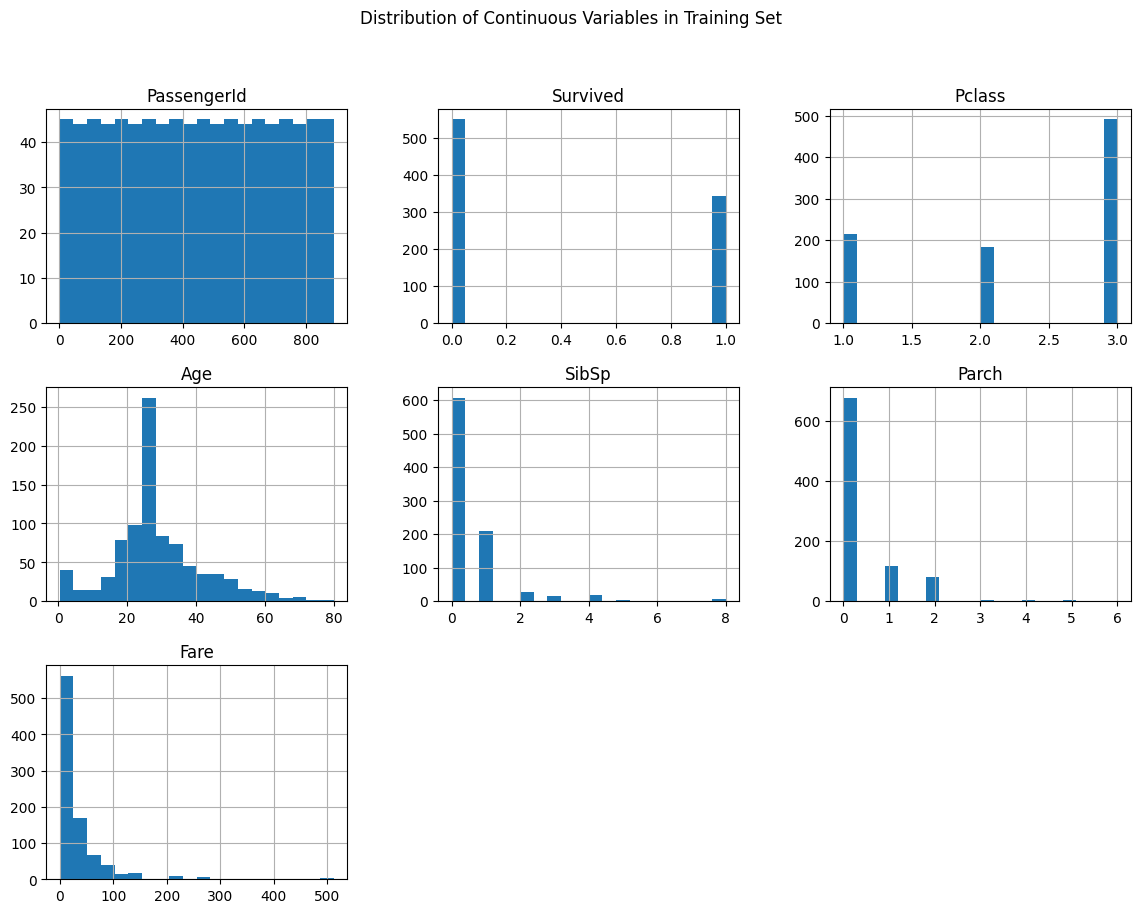

In [32]:
import matplotlib.pyplot as plt
df_train.hist(bins=20, figsize=(14,10))
plt.suptitle('Distribution of Continuous Variables in Training Set')
plt.show()

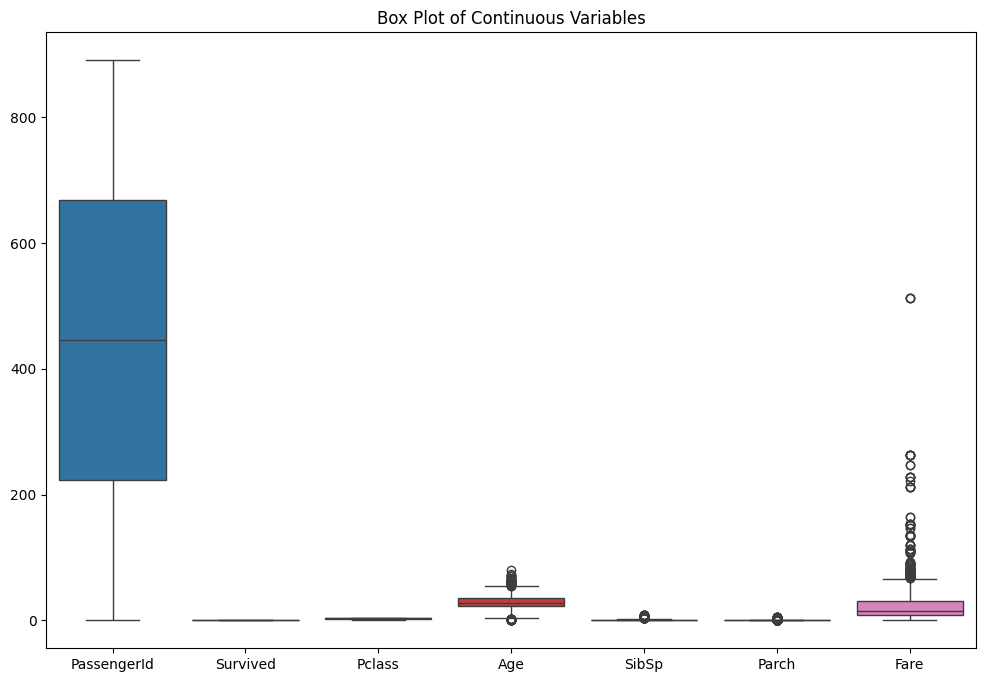

In [33]:
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_train.select_dtypes(include=['float64', 'int64']))
plt.title('Box Plot of Continuous Variables')
plt.show()


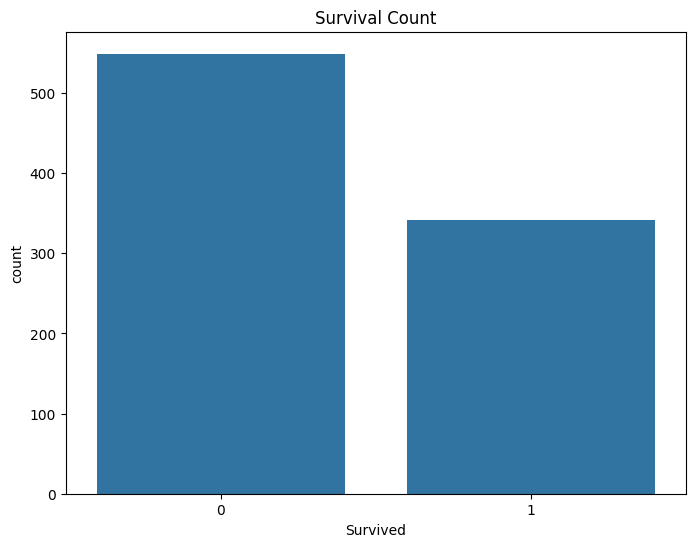

In [34]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Survived', data=df_train)
plt.title('Survival Count')
plt.show()

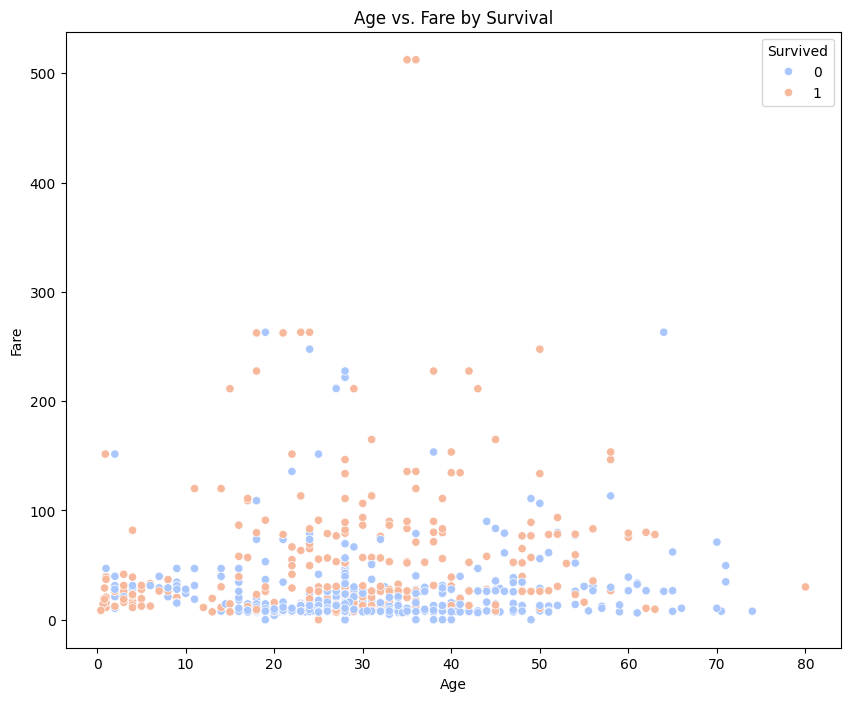

In [35]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_train, x='Age', y='Fare', hue='Survived', palette='coolwarm')
plt.title('Age vs. Fare by Survival')
plt.show()

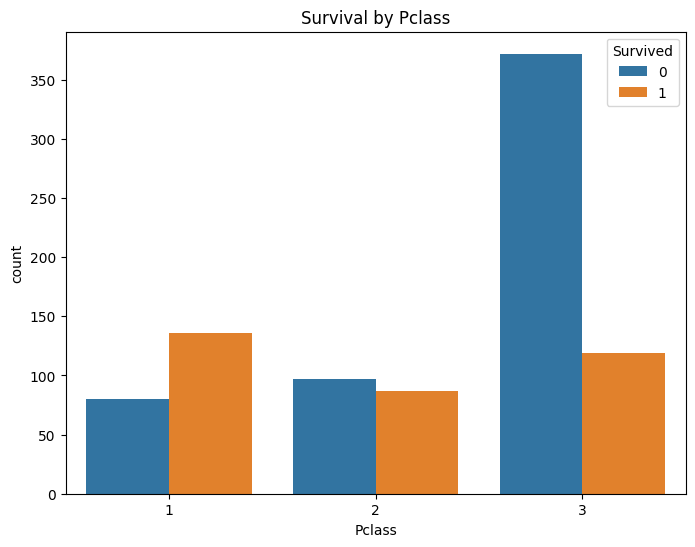

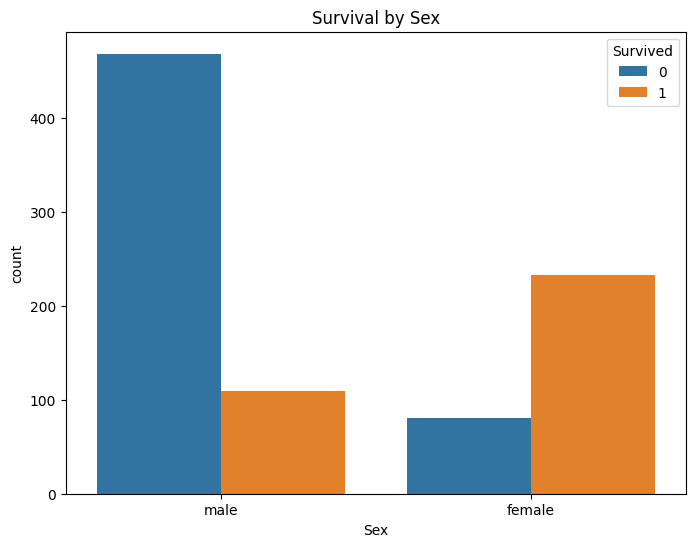

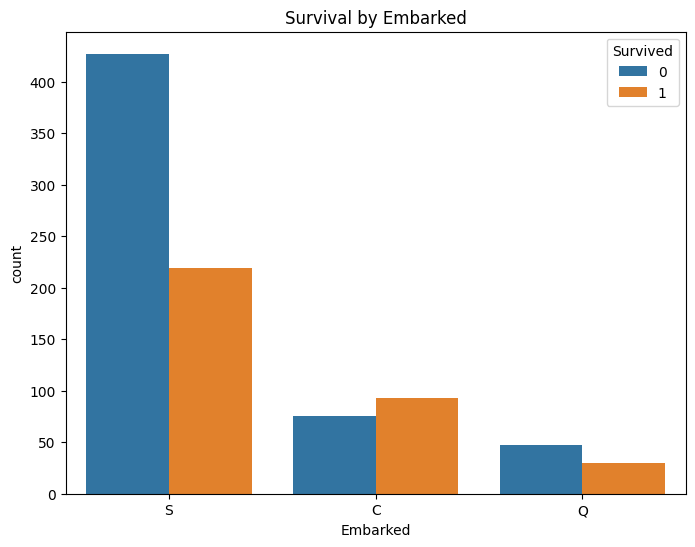

In [36]:
categorical_features = ['Pclass', 'Sex', 'Embarked']
for feature in categorical_features:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=feature, hue='Survived', data=df_train)
    plt.title(f'Survival by {feature}')
    plt.show()

In [37]:
# Encode categorical variables
df_train = pd.get_dummies(df_train, columns=['Sex', 'Embarked'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['Sex', 'Embarked'], drop_first=True)

In [38]:
# Ensure the same columns in both datasets
for col in df_train.columns:
    if col not in df_test.columns:
        df_test[col] = 0

for col in df_test.columns:
    if col not in df_train.columns:
        df_train[col] = 0

In [39]:
# Reorder the columns to match exactly
df_train = df_train[df_test.columns]

In [40]:
# Drop columns that are not useful for the model
df_train.drop(columns=['Name', 'Ticket'], inplace=True)
df_test.drop(columns=['Name', 'Ticket'], inplace=True)

In [41]:
# Feature scaling
scaler = StandardScaler()
features_to_scale = ['Age', 'Fare']
df_train[features_to_scale] = scaler.fit_transform(df_train[features_to_scale])
df_test[features_to_scale] = scaler.transform(df_test[features_to_scale])

In [42]:
# Separate the target variable from the features
try:
    X_train = df_train.drop(columns=['Survived'])
    y_train = df_train['Survived']

    X_test = df_test.drop(columns=['Survived'])
    y_test = df_test['Survived']
except KeyError as e:
    print(f"Error: {e} not found in the dataset columns.")
    exit()

In [43]:
# Build predictive models
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288


In [44]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [45]:
# Evaluate the models
def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

In [46]:
lgb_results = evaluate_model(y_test, y_pred_lgb)
xgb_results = evaluate_model(y_test, y_pred_xgb)

In [47]:
print(f'LightGBM Results: Accuracy={lgb_results[0]}, Precision={lgb_results[1]}, Recall={lgb_results[2]}, F1-score={lgb_results[3]}')
print(f'XGBoost Results: Accuracy={xgb_results[0]}, Precision={xgb_results[1]}, Recall={xgb_results[2]}, F1-score={xgb_results[3]}')

LightGBM Results: Accuracy=0.6626794258373205, Precision=0.0, Recall=0.0, F1-score=0.0
XGBoost Results: Accuracy=0.6674641148325359, Precision=0.0, Recall=0.0, F1-score=0.0
